### Loading Libraries

In [1]:
import os
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, filtfilt


### Data Preparation and Feature Extraction

In [2]:
# -----------------------------------
# Parameters
# -----------------------------------
csv_dir = "./mudra_data"  # path to your folder
window_size = 256  # 1 second if sampled at 256 Hz
step_size = 128    # 50% overlap
fs = 256           # sampling rate

In [3]:
# -----------------------------------
# 1. Bandpass Filter Function (for EMG/EEG)
# -----------------------------------
def bandpass_filter(signal, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut / nyq, highcut / nyq], btype='band')
    return filtfilt(b, a, signal)

In [4]:
# -----------------------------------
# 2. Feature Extraction per Window
# -----------------------------------
def extract_features(window):
    features = []
    for i in range(window.shape[1]):  # 3 channels
        signal = window[:, i]
        features.extend([
            np.mean(signal),
            np.std(signal),
            np.max(signal),
            np.min(signal),
            np.median(signal),
            np.percentile(signal, 25),
            np.percentile(signal, 75),
            np.ptp(signal),  # peak to peak
            np.sum(np.abs(np.diff(signal))),  # waveform length
            np.count_nonzero(np.diff(np.sign(signal)))  # zero crossings
        ])
    return features

In [5]:
# -----------------------------------
# 3. Sliding Window Segmenter
# -----------------------------------
def segment_signal(df, label):
    data = df[['Channel1', 'Channel2', 'Channel3']].values
    data = np.stack([
    bandpass_filter(data[:, 0], 20, 100, fs),   # EMG Right
    bandpass_filter(data[:, 1], 20, 100, fs),   # EMG Left
    bandpass_filter(data[:, 2], 0.5, 40, fs)    # EEG
], axis=1)


    X = []
    y = []
    for start in range(0, len(data) - window_size, step_size):
        window = data[start:start+window_size]
        features = extract_features(window)
        X.append(features)
        y.append(label)
    return X, y

### Loading data

In [6]:
# -----------------------------------
# 4. Load All CSVs and Process
# -----------------------------------
X_all = []
y_all = []

for fname in os.listdir(csv_dir):
    if fname.endswith(".csv"):
        path = os.path.join(csv_dir, fname)
        df = pd.read_csv(path)
        mudra_label = fname.replace(".csv", "")
        X, y = segment_signal(df, mudra_label)
        X_all.extend(X)
        y_all.extend(y)

print(f"Total windows: {len(X_all)}")

Total windows: 20030


In [7]:
X_all

[[np.float64(7.558600147401055e-05),
  np.float64(0.005754970165768006),
  np.float64(0.014029556955558445),
  np.float64(-0.01302942703049023),
  np.float64(0.0001975465051126823),
  np.float64(-0.004358974720992956),
  np.float64(0.004523001960991071),
  np.float64(0.027058983986048675),
  np.float64(1.0087021599447132),
  59,
  np.float64(5.044787345723376e-05),
  np.float64(0.004266879060539635),
  np.float64(0.012160757277811584),
  np.float64(-0.013479336806589309),
  np.float64(-0.00015413076172243357),
  np.float64(-0.0032230575429850875),
  np.float64(0.0031786991063334088),
  np.float64(0.02564009408440089),
  np.float64(0.7751210937268151),
  61,
  np.float64(0.00016373692571844574),
  np.float64(0.01122558103820932),
  np.float64(0.023328427942646546),
  np.float64(-0.023346510598026074),
  np.float64(0.0005474627175174182),
  np.float64(-0.008522357239224884),
  np.float64(0.0086979373469862),
  np.float64(0.04667493854067262),
  np.float64(1.3974783036544385),
  51],
 [np

In [8]:
# -----------------------------------
# 5. Train-Test Split
# -----------------------------------
X_all = np.array(X_all)
le = LabelEncoder()
y_all = le.fit_transform(y_all)

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, stratify=y_all, random_state=42)

### Random Forest

In [9]:
# -----------------------------------
# 6. Train Random Forest
# -----------------------------------
clf = RandomForestClassifier(n_estimators=50, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, random_state=42)

In [10]:
# -----------------------------------
# 7. Evaluate
# -----------------------------------
y_pred = clf.predict(X_test)

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Classification Report:

                 precision    recall  f1-score   support

  Chandra_mudra       1.00      1.00      1.00       406
    kamal_mudra       0.92      0.88      0.90       321
kanishtha_mudra       0.90      0.94      0.92       393
   mirghi_mudra       0.85      0.83      0.84       515
  mushthi_mudra       0.99      1.00      0.99       515
    prana_mufra       0.84      0.90      0.86       515
   pranam_mudra       1.00      1.00      1.00       451
   samana_mudra       0.92      0.88      0.90       515
    vajra_mudra       1.00      1.00      1.00       375

       accuracy                           0.93      4006
      macro avg       0.94      0.93      0.93      4006
   weighted avg       0.93      0.93      0.93      4006



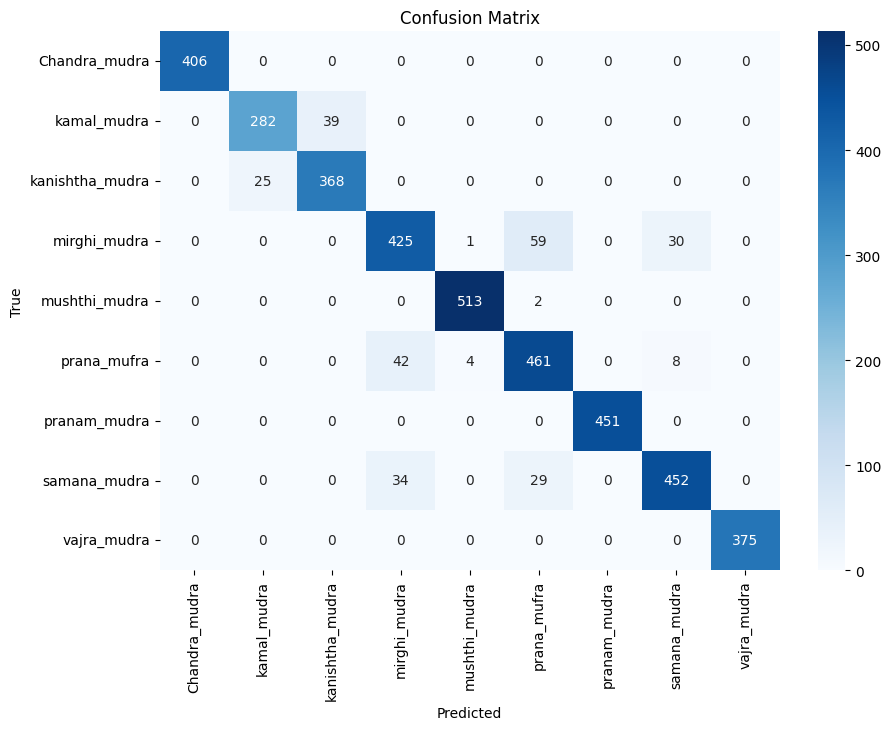

In [11]:
# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### SVM

In [12]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
# -----------------------------------
# 1. Build SVM Pipeline
# -----------------------------------
svm_clf = make_pipeline(
    StandardScaler(),       # Z-score normalization
    SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
)

In [14]:
# -----------------------------------
# 2. Train the SVM
# -----------------------------------
svm_clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(random_state=42))])

In [15]:
# -----------------------------------
# 3. Evaluate
# -----------------------------------
y_pred = svm_clf.predict(X_test)

print("SVM Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

SVM Classification Report:

                 precision    recall  f1-score   support

  Chandra_mudra       1.00      1.00      1.00       406
    kamal_mudra       0.93      0.86      0.89       321
kanishtha_mudra       0.89      0.95      0.92       393
   mirghi_mudra       0.75      0.77      0.76       515
  mushthi_mudra       0.98      0.99      0.99       515
    prana_mufra       0.80      0.84      0.82       515
   pranam_mudra       1.00      1.00      1.00       451
   samana_mudra       0.89      0.83      0.86       515
    vajra_mudra       1.00      1.00      1.00       375

       accuracy                           0.91      4006
      macro avg       0.92      0.91      0.92      4006
   weighted avg       0.91      0.91      0.91      4006



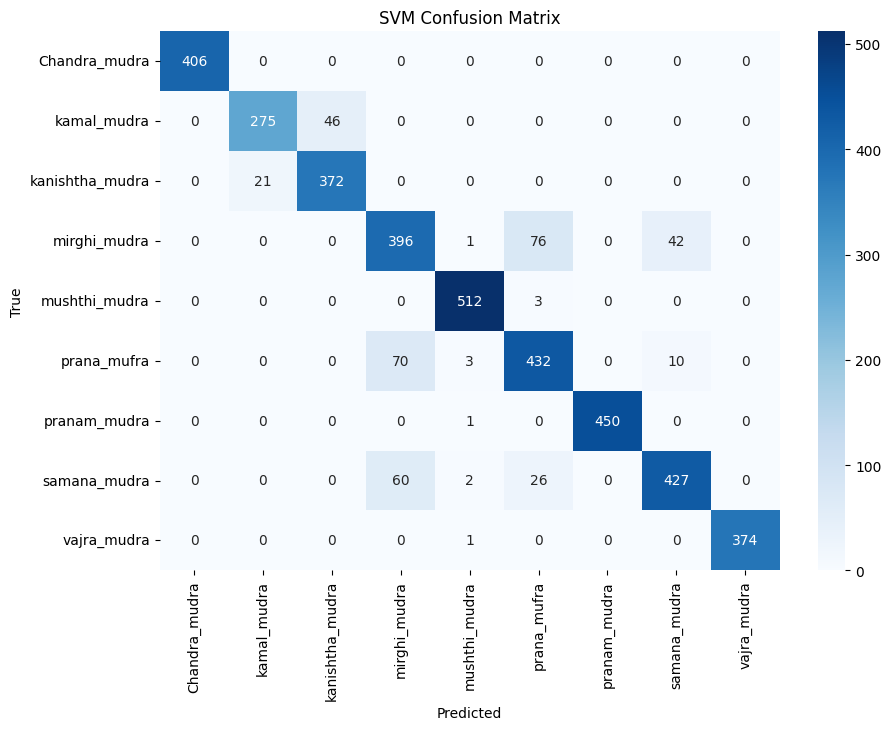

In [16]:
# -----------------------------------
# 4. Confusion Matrix
# -----------------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("SVM Confusion Matrix")
plt.show()


### Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
# -----------------------------------
# 1. Create Pipeline
# -----------------------------------
logreg_clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial', random_state=42)
)

In [19]:
# -----------------------------------
# 2. Train
# -----------------------------------
logreg_clf.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, multi_class='multinomial',
                                    random_state=42))])

In [20]:
# -----------------------------------
# 3. Evaluate
# -----------------------------------
y_pred = logreg_clf.predict(X_test)

In [21]:
print("Logistic Regression Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Logistic Regression Classification Report:

                 precision    recall  f1-score   support

  Chandra_mudra       1.00      1.00      1.00       406
    kamal_mudra       0.81      0.84      0.83       321
kanishtha_mudra       0.87      0.84      0.85       393
   mirghi_mudra       0.74      0.77      0.75       515
  mushthi_mudra       1.00      0.99      1.00       515
    prana_mufra       0.81      0.80      0.81       515
   pranam_mudra       1.00      1.00      1.00       451
   samana_mudra       0.86      0.85      0.86       515
    vajra_mudra       1.00      1.00      1.00       375

       accuracy                           0.90      4006
      macro avg       0.90      0.90      0.90      4006
   weighted avg       0.90      0.90      0.90      4006



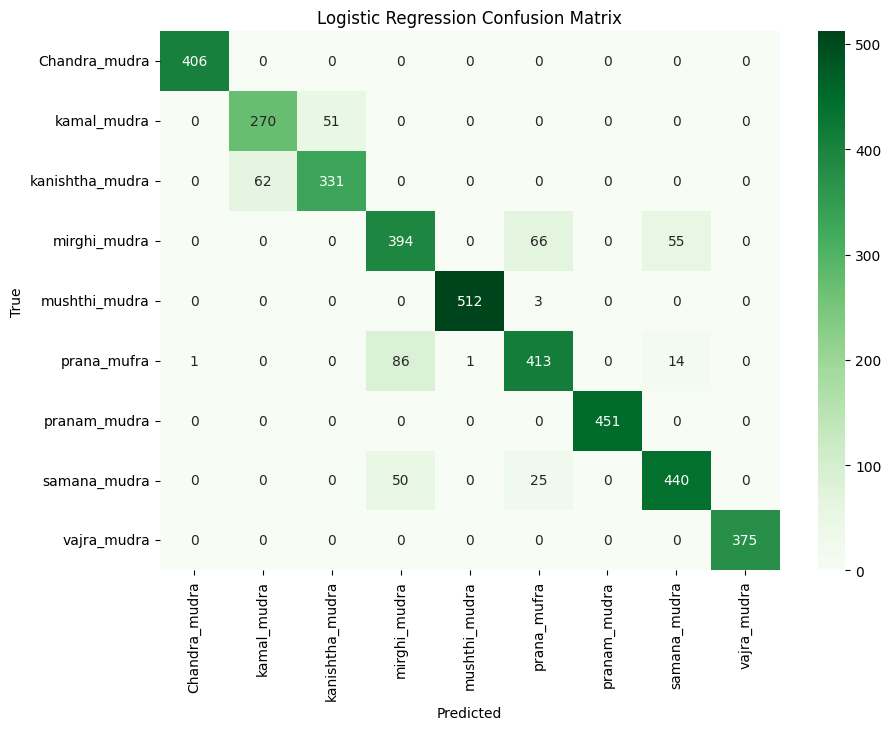

In [22]:
# -----------------------------------
# 4. Confusion Matrix
# -----------------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Greens")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Logistic Regression Confusion Matrix")
plt.show()


### Gaussian Naive Bayes

In [23]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
# -----------------------------------
# 1. Create GNB pipeline
# -----------------------------------
gnb_clf = make_pipeline(
    StandardScaler(),       # Important for GNB performance
    GaussianNB()
)


In [25]:
# -----------------------------------
# 2. Train
# -----------------------------------
gnb_clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gaussiannb', GaussianNB())])

In [26]:
# -----------------------------------
# 3. Evaluate
# -----------------------------------
y_pred = gnb_clf.predict(X_test)

In [27]:
print("Gaussian Naive Bayes Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Gaussian Naive Bayes Classification Report:

                 precision    recall  f1-score   support

  Chandra_mudra       1.00      1.00      1.00       406
    kamal_mudra       0.85      0.83      0.84       321
kanishtha_mudra       0.86      0.89      0.87       393
   mirghi_mudra       0.53      0.76      0.63       515
  mushthi_mudra       0.97      0.86      0.91       515
    prana_mufra       0.72      0.56      0.63       515
   pranam_mudra       1.00      1.00      1.00       451
   samana_mudra       0.84      0.75      0.80       515
    vajra_mudra       1.00      1.00      1.00       375

       accuracy                           0.84      4006
      macro avg       0.86      0.85      0.85      4006
   weighted avg       0.85      0.84      0.84      4006



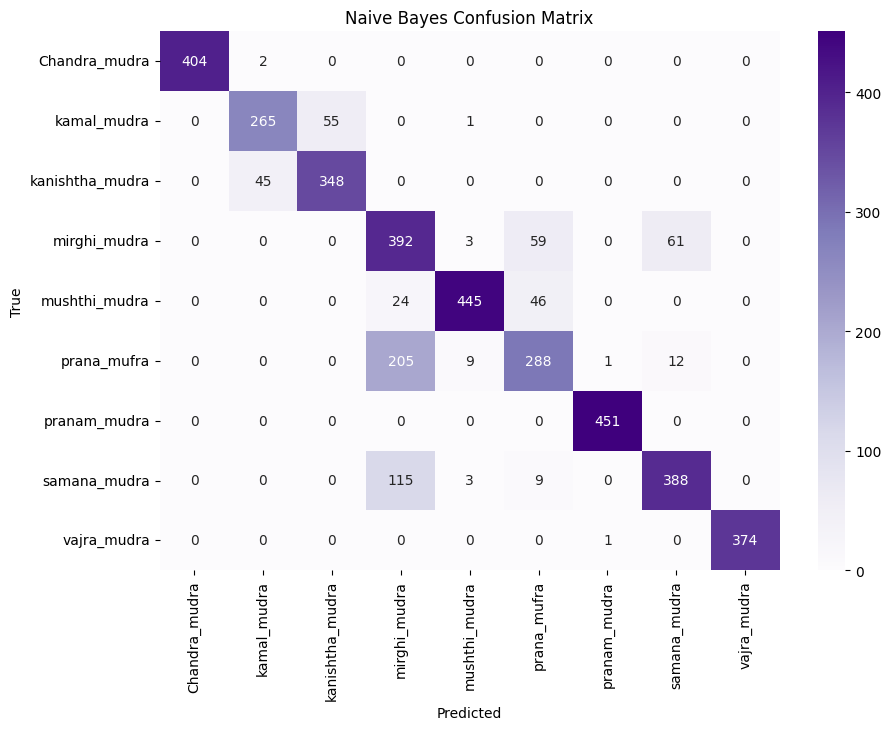

In [28]:
# -----------------------------------
# 4. Confusion Matrix
# -----------------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Purples")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Naive Bayes Confusion Matrix")
plt.show()